In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathos.multiprocessing as mp
import xarray as xr
#from telemetry_module import *
from copy import deepcopy
import pickle
import time
from statsmodels.graphics import tsaplots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [56]:
from scipy.special import logit, expit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, PowerTransformer
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.linear_model import ARDRegression, LinearRegression, BayesianRidge, Lasso
from sklearn.linear_model import LassoCV, Ridge, RidgeCV, LassoLarsIC

In [57]:
from bayesfilt.telemetry.utils import *
from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *

In [ ]:
%%time
df = get_annotated_telemetry_df()

1000000  out of  2892231


In [ ]:
# fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks_ca_annotated_calibrated')
# df.to_parquet(fpath)
# df[['Heading','HeadingRate','HeadingRateRaw']].iloc[1100:1100+17]
df.info(verbose=True, show_counts=True)

In [8]:
df[['Heading','HeadingRate','HeadingRateSmooth', 'HeadingRateFd']].iloc[1100:1100+17]

,Heading,HeadingRate,HeadingRateSmooth,HeadingRateFd
1183921,-167.653473,-1.036129,-0.988721,-3.100067
1698897,-32.544250,-7.483450,-6.697386,-7.077085
4055952,133.917465,7.536994,6.444666,5.000092
2153598,139.898834,1.364332,1.381930,-3.622269
6290477,147.028198,-0.576574,-1.029747,-1.457718
2288324,166.886917,0.161579,0.079799,0.431030
8469108,-95.037575,0.234369,-0.178064,1.307404
3522558,91.611595,-0.043611,-0.117236,-1.374756
5078267,-96.021339,-3.075854,-4.499680,-5.593719
3161048,111.034607,-3.277902,-4.594887,11.983139


<AxesSubplot: >

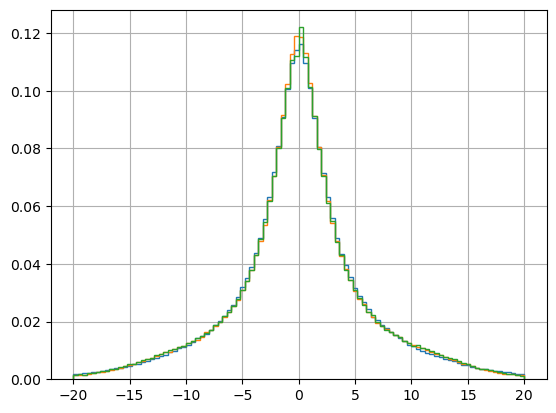

In [10]:
df.HeadingRate.hist(bins=100, density=True, histtype='step')
#df.HeadingRateFd.hist(bins=100, density=True, histtype='step')
df.HeadingRateSmooth.hist(bins=100, density=True, histtype='step', range=(-20,20))
df.HeadingRateFdSmooth.hist(bins=100, density=True, histtype='step', range=(-20,20))

In [52]:
varnames = ['HeadingRate', 'HeadingRateSmooth', 'HeadingRateFdSmooth']
varnames = ['VelocityVer', 'AccelerationVer']
varnames = ['VelocityHor', 'AccelerationVer']
#varnames = ['HeadingRateSmooth', 'AccelerationVer']
corr_dict = {}
tlags = [5, 10,20, 30,45, 60]
for yname in varnames:
    corr_dict[yname] = []
    for ilag in tlags:
        xname = f'{yname}Lag{ilag}'
        icorr = df[xname].corr(df[yname])
        corr_dict[yname].append(icorr)

KeyError: 'VelocityVer'

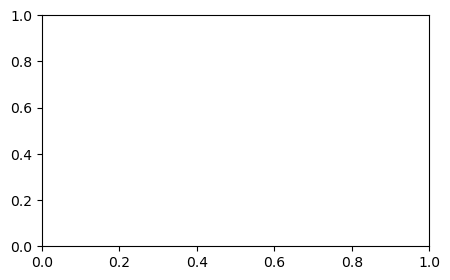

In [53]:
fig, ax = plt.subplots(figsize=(5,3))
#ax.plot([0]+tlags, [1]+corr_dict['VelocityHor'], '-r', color=clrs[0], label='Horizontal velocity')
ax.plot([0]+tlags, [1]+corr_dict['VelocityVer'], '-r', color=clrs[1], label='Vertical velocity')
#ax.plot([0]+tlags, [1]+corr_dict['AccnHorSmooth'], '-r', color=clrs[8], label='Hor accn smooth')
#ax.plot([0]+tlags, [1]+corr_dict['AccelerationHor'], '-r', color=clrs[1], label='Hor accn')
ax.plot([0]+tlags, [1]+corr_dict['AccelerationVer'], '-r', color=clrs[4], label='Vertical accn')
#ax.plot([0]+tlags, [1]+corr_dict['AccelerationVerB'], '-r', color=clrs[0], label='Vertical accnB')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRate'], '-r', color=clrs[2], label='Heading rate')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateFd'], '-r', color=clrs[3], label='Heading rate fd')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateSmooth'], '-r', color=clrs[5], label='Heading rate smooth')
#ax.plot([0]+tlags, [1]+corr_dict['HeadingRateFdSmooth'], '-r', color=clrs[6], label='Heading rate fd smooth')
ax.legend(borderaxespad=0., ncol=1, loc=1)
ax.set_xlabel('Difference in orographic updraft from NF/CF [m/s]')
#ax.set_ylabel('Heading rate, median [deg/s]')
ax.grid(True)
#ax.set_xlim([-0.1,0.1])
#ax.set_ylim([8,12])
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
lim = (-0.5,0.5)
for icol in [ix for ix in df.columns if '15Diff' in ix]:
    df[icol].hist(bins=100, ax=ax[0], range=lim, histtype='step')
for icol in [ix for ix in df.columns if '30Diff' in ix]:
    df[icol].hist(bins=100, ax=ax[1], range=lim, histtype='step')
for icol in [ix for ix in df.columns if '60Diff' in ix]:
    df[icol].hist(bins=100, ax=ax[2], range=lim, histtype='step')

In [ ]:
# compute lagged, next and change version of predictable vars
#df['AglMod'] = expit(df['AltitudeAgl']/25. - 4.)
#df['HeadingRateChange'] = df['HeadingRate'].diff()
#df['HeadingRate'] = df['HeadingRateRaw'].rolling(3, min_periods=1, center=True).mean().bfill().ffill()
#df['HrateByHspeed'] = df['HeadingRate'].divide(df['VelocityHor'].clip(lower=0.5, upper=np.inf))
#varnames = ['VelocityHor', 'HeadingRate', 'HeadingRateAbs', 'VelocityVer']
time_lags = [5, 10, 30, 60, 120]
variables = {}
variables['Pred'] = ['VelocityHor', 'HeadingRate', 'VelocityVer']
#variables['Pred'] = ['VelocityHor', 'HrateByHspeed', 'VelocityVer']
#variables['PredChange'] = [f'{ix}Change' for ix in variables['Pred']]
variables['PredNext'] = [f'{ix}Next' for ix in variables['Pred']]
for i, ivar in enumerate(variables['Pred']):
    #df[variables['PredChange'][i]] = df[ivar].diff(-1).ffill().bfill()
    df[variables['PredNext'][i]] = df[ivar].shift(-1).ffill().bfill()
for ilag in time_lags:
    variables[f'PredLag{ilag}'] = [f'{ix}Lag{ilag}' for ix in variables['Pred']]
    for ix, iy in zip(variables[f'PredLag{ilag}'], variables['Pred']):
        df[ix] = df[iy].shift(ilag).ffill().bfill()
        #df[ix] = df[iy].diff(ilag).ffill().bfill()
        # df[ix] = df[iy] - df[iy].shift(ilag).ffill().bfill()
        #df[ix] = df[iy].shift(ilag).ffill().bfill()
variables

In [ ]:
[ix for ix in df.columns if 'Oro' in ix]

In [ ]:
# standardize all the variables 
std_choice = 'robust'
if std_choice == 'robust':
    std_transformer = RobustScaler(unit_variance=True, quantile_range=(5.0, 95.0))
elif std_choice == 'quantile':
    std_transformer = QuantileTransformer(output_distribution='normal')
elif std_choice == 'standard':
    std_transformer = StandardScaler()
else:
    print('invalid std choice')
# dfshort['OroSmoothNearLeftDiff'] = np.maximum.reduce([
#     dfshort['OroSmoothNearL15Diff'],
#     dfshort['OroSmoothNearL30Diff'],
#     dfshort['OroSmoothNearL60Diff']
# ])
# dfshort['OroSmoothNearRightDiff'] = np.maximum.reduce([
#     dfshort['OroSmoothNearR15Diff'],
#     dfshort['OroSmoothNearR30Diff'],
#     dfshort['OroSmoothNearR60Diff']
# ])
variables['Env'] = [
    'Agl', 'OroSmooth', 'HeadingRateAbs',
    'WindSpeed80m',  'WindSupport80m',  'WindLateral80m', 'WindLateral80mAbs',
    #'OroSmoothNearLeftDiff', 'OroSmoothNearRightDiff',
    
    'ElevFiftyDiff', 'ElevOnehdDiff', 'ElevTwohdDiff', 'ElevFvehdDiff', 'ElevOnekmDiff',
    'OroSmoothFiftyDiff', 'OroSmoothOnehdDiff', 'OroSmoothTwohdDiff', 'OroSmoothFvehdDiff', 'OroSmoothOnekmDiff',
    
    'OroSmoothFiftyL15Diff', 'OroSmoothFiftyR15Diff',
    'OroSmoothFiftyL30Diff', 'OroSmoothFiftyR30Diff',
    'OroSmoothFiftyL60Diff', 'OroSmoothFiftyR60Diff',
    
    'OroSmoothOnehdL15Diff', 'OroSmoothOnehdR15Diff', 
    'OroSmoothOnehdL30Diff', 'OroSmoothOnehdR30Diff', 
    'OroSmoothOnehdL60Diff', 'OroSmoothOnehdR60Diff',
    
    'OroSmoothTwohdL15Diff', 'OroSmoothTwohdR15Diff', 
    'OroSmoothTwohdL30Diff', 'OroSmoothTwohdR30Diff', 
    'OroSmoothTwohdL60Diff', 'OroSmoothTwohdR60Diff',
]
idict = {ix:iy for ix,iy in variables.items() if 'Std' not in ix}
std_funcs = {}
for key, varlist in idict.items():
    print(key,': ', *varlist)
    variables[f'{key}Std'] = [f'{ix}Std' for ix in varlist]
    for ix, iy in zip(variables[f'{key}Std'], varlist):
        dfshort[ix] =  std_transformer.fit_transform(np.atleast_2d(dfshort[iy].values).T)
        std_funcs[ix] = deepcopy(std_transformer)

In [ ]:
model_str = f'fit_ca.pickle_{std_choice}'
with open(os.path.join(OUT_DIR, f'{model_str}_df'), "wb") as f:
    pickle.dump(dfshort, f)

In [ ]:
fig, ax = plt.subplots(figsize=(5,2.5))
# #dfshort['GroundSlope'].hist(bins=100, ax=ax, histtype='step')
# rnge = (-300,1000)
# dfshort['WindLateral80m'].hist(bins=100, ax=ax, histtype='step')
# dfshort['WindSupport80m'].hist(bins=100, ax=ax, histtype='step')
#dfshort['WindLateral80mMod'].hist(bins=100, ax=ax, histtype='step')
# #dfshort['HeadingRateNextStdLinRegRes'].hist(bins=100, ax=ax, histtype='step')
# for icase in cases:
#     #dfshort[f'Elev{icase}Diff'].hist(bins=100, ax=ax, histtype='step')
#     #dfshort[f'OroSmooth{icase}'].hist(bins=100, ax=ax, histtype='step')
#     dfshort[f'OroSmooth{icase}Diff'].hist(bins=100, ax=ax, histtype='step')
#dfshort['OroSmoothNearDiff'].hist(bins=100, ax=ax, histtype='step')
#dfshort['OroSmoothNearL30DiffStd'].hist(bins=100, ax=ax, histtype='step')
#dfshort['OroSmoothNearR30DiffStd'].hist(bins=100, ax=ax, histtype='step')
# dfshort['OroSmoothCloseL30DiffStd'].hist(bins=100, ax=ax, histtype='step')
# dfshort['OroSmoothCloseR30DiffStd'].hist(bins=100, ax=ax, histtype='step')
# dfshort['OroSmoothMidDiff'].hist(bins=100, ax=ax, histtype='step')
# dfshort['OroSmoothFarDiff'].hist(bins=100, ax=ax, histtype='step')
#dfshort['OroSmoothFartherDiff'].hist(bins=100, ax=ax, histtype='step',range=rnge)
#dfshort['WindSpeed80m'].hist(bins=100, ax=ax, histtype='step')
#dfshort['WindDirection80m'].hist(bins=100, ax=ax, histtype='step')
#dfshort['WindRelativeAngle80m'].hist(bins=100, ax=ax, histtype='step')
# dfshort['VelocityVerStd'].hist(bins=100, ax=ax, histtype='step', color='b')
# dfshort['VelocityVer'].hist(bins=100, ax=ax, histtype='step', color='b')
#dfshort['TrackTimeElapsed'].hist(bins=100, ax=ax, histtype='step', color='b', range=(0,100))
# #dfshort['VelocityHor'].hist(bins=100, ax=ax, histtype='step', color='b')
varname = 'VelocityVer'#'HrateByHspeed'
for ilag in time_lags:
    dfshort[f'{varname}Lag{ilag}'].hist(bins=100, ax=ax, histtype='step', color='r')
# dfshort[f'{varname}Next'].hist(bins=100, ax=ax, histtype='step', color='b')
#dfshort['HeadingRate30ago'].hist(bins=100, ax=ax, histtype='step', color='r', range=(-10,10))
# dfshort['WindSupport80m'].hist(bins=100, ax=ax, histtype='step')
# dfshort['WindLateral80mAbs'].hist(bins=100, ax=ax, histtype='step')
# dfshort['WindLateral80m'].hist(bins=100, ax=ax, histtype='step')

In [ ]:
model_structure = {}
model_structure.clear()
for ix in variables['PredNextStd']:
    model_structure[ix] = deepcopy(variables['EnvStd'])
# dfshort['AglStdFifth'] = dfshort['AglStd'].pow(5)
# dfshort['AglStdCubic'] = dfshort['AglStd'].pow(3)
model_structure['VelocityHorNextStd'] = [
    'AglStd', #'AglNearStd', 'AglMidStd', 'AglFarStd',
    'ElevFiftyDiffStd', 'ElevOnehdDiffStd', 'ElevTwohdDiffStd', 'ElevFvehdDiffStd', 'ElevOnekmDiffStd',
    'OroSmoothStd',  'WindSupport80mStd', #'WindLateral80mStd', 
    'OroSmoothFiftyDiffStd','OroSmoothCloseDiffStd', #'OroSmoothMidDiffStd', 'OroSmoothFarDiffStd', 'OroSmoothFartherDiffStd',
    'VelocityVerStd',  
    #'VelocityVerLag10Std', 
    #'VelocityVerLag30Std', 'VelocityVerLag60Std', 'VelocityVerLag120Std',
    'HeadingRateAbsStd', 
    #'HeadingRateLag10Std', 'HeadingRateLag30Std',  'HeadingRateLag60Std', 'HeadingRateLag120Std', 
    #'VelocityHorLag10Std', 
    'VelocityHorLag30Std', #'VelocityHorLag60Std',  'VelocityHorLag120Std'
]
model_structure['VelocityVerNextStd'] = [
    'AglStd', #'AglStdCubic', 'AglStdFifth', #'AglNearStd', 'AglMidStd', 'AglFarStd',
    'ElevNearDiffStd', #'ElevCloseDiffStd', 'ElevMidDiffStd', 'ElevFarDiffStd', 'ElevFartherDiffStd',
    'OroSmoothStd',  'WindSupport80mStd', 'WindLateral80mAbsStd', #'WindLateral80mStd',
    'OroSmoothNearDiffStd', #'OroSmoothCloseDiffStd', #'OroSmoothMidDiffStd', 'OroSmoothFarDiffStd','OroSmoothFartherDiffStd',
    'VelocityHorStd', 
    #'VelocityHorLag10Std', 
    #'VelocityHorLag30Std','VelocityHorLag60Std',#'VelocityHorLag120Std',
    'HeadingRateAbsStd', 
    #'HeadingRateLag10Std','HeadingRateLag30Std', 'HeadingRateLag60Std','HeadingRateLag120Std',
    #'VelocityVerLag10Std', 
    'VelocityVerLag30Std','VelocityVerLag120Std',
]
model_structure['HeadingRateNextStd'] = [
    #'AglStd',
    'OroSmoothNearLeftDiffStd', 'OroSmoothNearRightDiffStd',
#     'OroSmoothNearL15DiffStd', 'OroSmoothNearR15DiffStd',
#     'OroSmoothNearL30DiffStd', 'OroSmoothNearR30DiffStd',
#     'OroSmoothNearL60DiffStd', 'OroSmoothNearR60DiffStd',
#     'OroSmoothCloseL15DiffStd', 'OroSmoothCloseR15DiffStd',
#     'OroSmoothCloseL30DiffStd', 'OroSmoothCloseR30DiffStd',
#     'OroSmoothCloseL60DiffStd', 'OroSmoothCloseR60DiffStd',
    #'ElevNearDiffStd', 'ElevCloseDiffStd', 'ElevMidDiffStd', 'ElevFarDiffStd',
    #'WindLateral80mStd', #'WindSupport80mStd',
    #'OroSmoothStd',
    #'VelocityHorStd', #'VelocityHorLag5Std','VelocityHorLag10Std', 'VelocityHorLag20Std',
    #'VelocityVerStd', #'VelocityVerLag5Std', 'VelocityVerLag10Std', 'VelocityVerLag20Std',
    'HeadingRateLag5Std', 'HeadingRateLag10Std', #'HeadingRateLag30Std', #'HeadingRateLag60Std', #'HeadingRateLag120Std' 
]
# model_structure['HrateByHspeedNextStd'] = [
#     'OroSmoothNearL30DiffStd', 'OroSmoothNearR30DiffStd',
#     'OroSmoothCloseL30DiffStd', 'OroSmoothCloseR30DiffStd',
#     #'ElevNearDiffStd', 'ElevMidDiffStd', 'ElevFarDiffStd',
#     'WindLateral80mAbsStd', #'WindSupport80mStd',
#     'VelocityVerStd', #'VelocityHorStd', 'OroSmoothStd',
#     #'VelocityHorStd', #'VelocityHorLag5Std','VelocityHorLag10Std', 'VelocityHorLag20Std',
#     #'VelocityVerStd', 'VelocityVerLag5Std', 'VelocityVerLag10Std', 'VelocityVerLag20Std',
#     #'HrateByHspeedLag5Std', 
#     #'HrateByHspeedLag10Std', 'HrateByHspeedLag30Std',#'HeadingRateLag60Std', #'HeadingRateLag120Std' 
#]


In [ ]:
regressors = {
    #'lasso': LassoCV(fit_intercept=True, cv=4, selection='random', n_alphas=100, eps=1e-2,
    #                 tol=1e-3, n_jobs=4, verbose=False, max_iter=20000),
    #'Ard': ARDRegression(compute_score=True, fit_intercept=True, n_iter=400, tol=1e-2, verbose=False),
    'LinReg': LinearRegression(fit_intercept=True, n_jobs=8, copy_X=True)
}
poly_func_dict = {
    'VelocityHorNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=True),
    'VelocityVerNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=True),
    'HeadingRateNextStd': PolynomialFeatures(degree=7, include_bias=False, interaction_only=False),
}
poly_func_dict = {
    'VelocityHorNextStd': PolynomialFeatures(degree=1, include_bias=False, interaction_only=False),
    'VelocityVerNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
    'HeadingRateNextStd': PolynomialFeatures(degree=7, include_bias=False, interaction_only=False),
    #'HrateByHspeedNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
}
poly_func_error_dict = {
    'VelocityHorNextStd': PolynomialFeatures(degree=1, include_bias=False, interaction_only=False),
    'VelocityVerNextStd': PolynomialFeatures(degree=1, include_bias=False, interaction_only=False),
    'HeadingRateNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
    #'HrateByHspeedNextStd': PolynomialFeatures(degree=3, include_bias=False, interaction_only=False),
}
models = {}
models.clear()
for pred_var, covariates in model_structure.items():
    poly_funcs = poly_func_dict[pred_var]
    X_features = poly_funcs.fit_transform(dfshort.loc[:, covariates].values)
    poly_funcs.feature_names_in_ = covariates
    model = {}
    model['Covariates'] = covariates
    model['Features'] = poly_funcs
    result_df = pd.DataFrame(index=list(poly_funcs.get_feature_names_out()) + ['Bias', 'Score'])
    for reg_name, regressor in regressors.items():
        
        # mean modeling
        Yvec = dfshort.loc[:, pred_var].values
        start_time = time.time()
        fitted_model = regressor.fit(X_features, Yvec)
        dfshort[f'{pred_var}{reg_name}'] = fitted_model.predict(X_features)
        model[reg_name] = deepcopy(fitted_model)
        score = np.around(fitted_model.score(X_features, Yvec),3)
        coeff_val = np.around(fitted_model.coef_[:], 5)
        result_df[f'{pred_var}{reg_name}'] = list(coeff_val) + [fitted_model.intercept_, score]
        # error modeling
        
        
        res_vec = Yvec - fitted_model.predict(X_features)
        dfshort[f'{pred_var}{reg_name}Res'] = res_vec
        res_vec = (Yvec - fitted_model.predict(X_features))**2
        #res_vec = np.abs(Yvec - fitted_model.predict(X_features))
        dfshort[f'{pred_var}{reg_name}Error'] = res_vec
        poly_funcs_error = poly_func_error_dict[pred_var]
        X_features_error = poly_funcs_error.fit_transform(dfshort.loc[:, covariates].values)
        poly_funcs_error.feature_names_in_ = covariates
        model['FeaturesError'] = poly_funcs_error
        fitted_error_model = regressor.fit(X_features_error, res_vec)
        model[f'{reg_name}Error'] = deepcopy(fitted_error_model)
        dfshort[f'{pred_var}{reg_name}ErrorPred']  = fitted_error_model.predict(X_features_error)
        score_err = np.around(fitted_error_model.score(X_features_error, res_vec), 3)
        #result_df[f'{pred_var}{reg_name}Error'] = list(coeff_val) + [fitted_error_model.intercept_, score_err]
        
        #end
        run_time = np.around(((time.time() - start_time)) / 60., 2)
        print(f'{reg_name}-{pred_var}-{score}-{score_err}-took {run_time} mins', flush=True)
    model['df'] = pd.DataFrame(result_df)
    models[pred_var] = model
models = pd.DataFrame(models)

In [ ]:
pred_vars =  ['VelocityVerNextStd','VelocityHorNextStd','HeadingRateNextStd']
#pred_vars = ['VelocityVerNextStd','VelocityHorNextStd','HrateByHspeedNextStd']
ylim = None
for pred in pred_vars:
    print(pred)
    fig, ax = plot_relation(dfshort, pred, model_structure[pred],  quant=0.95, clr='b', 
                            lags=True, ylim=ylim)
    _,_ = plot_relation(dfshort, f'{pred}LinReg', model_structure[pred],  quant=0.95, 
                        clr='r', fig=fig, ax=ax, lags=True, ylim=ylim)
    legend_elements = [Line2D([0], [0], color='r', ls='-',lw=2, label='Calibrated model'),
                       Line2D([0], [0], color='b', ls='-', lw=2, label='Data')]
    ax[-1].legend(handles=legend_elements, loc='upper left',)
    #plt.savefig(os.path.join(fig_dir, f'{pred}.png'))
#  title='Mean of conditional disribution'
#plt.legend(handles=[red_patch])

In [ ]:
for pred in pred_vars:
    print(pred)
    fig, ax = plot_relation(dfshort, f'{pred}LinRegError', model_structure[pred],  quant=0.95, 
                            clr='b', lags=True, ylim=None)
    _,_ = plot_relation(dfshort, f'{pred}LinRegErrorPred', model_structure[pred],  quant=0.95, 
                        clr='r', fig=fig, ax=ax, lags=True, ylim=None)
    legend_elements = [Line2D([0], [0], color='r', ls='-',lw=2, label='Calibrated model'),
                       Line2D([0], [0], color='b', ls='-', lw=2, label='Data')]
    ax[-1].legend(handles=legend_elements, loc='upper left',)

In [ ]:
model_str = f'fit_ca.pickle_{std_choice}'
with open(os.path.join(OUT_DIR, f'{model_str}_model'), "wb") as f:
    pickle.dump(models, f)
with open(os.path.join(OUT_DIR, f'{model_str}_funcs'), "wb") as f:
    pickle.dump(std_funcs, f)
with open(os.path.join(OUT_DIR, f'{model_str}_df'), "wb") as f:
    pickle.dump(dfshort, f)

In [ ]:
std_funcs['OroSmoothStd'].inverse_transform(np.atleast_2d([0.6]))

### JUnk

In [ ]:
# for ivar in model_structure[pred]:
#     #ivar = ivar.split('Std')[0]
#     #pred = pred.split('Std')[0]
#     fig, ax = plot_2drelation(dfshort, ivar, pred, quant=0.95, nsamples=100000, scatter=False, clr='b')
#     plot_2drelation(dfshort, ivar, f'{pred}LinReg', quant=0.95, nsamples=100000, fig=fig, ax=ax,clr='r')
#     print(pred, ivar, dfshort[pred].corr(dfshort[ivar]))

In [ ]:
# # classify flight modes
# rolling_time = 20.
# vspeed_roll = df['SpeedVer'].rolling(int(rolling_time), center=True).mean().bfill().ffill()
# headingrate_roll = df['HeadingRateHor'].abs().rolling(int(rolling_time), center=True).mean().bfill().ffill()
# vspeed_classifier = {'Gliding': (-1000, -1), 'Oro_soaring':(-1,1000.), 'Thermal_soaring': (1.,1000.)}
# hrate_classifier = {'Gliding': (0, 5), 'Oro_soaring':(0, 5.), 'Thermal_soaring': (6.,1000)}
# df['FlightMode'] = 'U'
# for key, val in vspeed_classifier.items():
#     #print(key, val, hrate_classifier[key])
#     ibool = (vspeed_roll.between(*val)) & (headingrate_roll.between(*hrate_classifier[key]))
#     df.loc[ibool, 'FlightMode'] =  key[0].upper()
#     print(key, ' : ', np.around(ibool.sum()*100/df.shape[0],2))

In [ ]:
df['AglMode'] = 'U'
agl_classifier = {'Low_agl': (-1000, 250), 'high_agl':(250,100000.), }
for key, val in agl_classifier.items():
    #print(key, val, hrate_classifier[key])
    ibool = df['AltitudeAGL'].between(*val)
    df.loc[ibool, 'AglMode'] =  key[0].upper()
    print(key, ' : ', np.around(ibool.sum()*100/df.shape[0],2))

In [ ]:
# predictables
df['HeadingRateHorAbs'] = df['HeadingRateHor'].abs()
Y_colnames = ['AccnVer', 'AccnHorTangential', 'HeadingRateHorAbs']
Y_varnames = [f'{icol}_Next' for icol in Y_colnames] 
for icol, ivar in zip(Y_colnames, Y_varnames):
    df[ivar] = df.groupby('TrackID')[icol].shift(-1).ffill()

## Model calibration

In [ ]:
X_varnames = []
X_varnames +=  ['AltitudeAGL', 'AltitudeAGL_5ago',  'AltitudeAGL_10ago']
X_varnames += ['SpeedVer', 'SpeedVer_5ago', 'SpeedVer_10ago']
X_varnames += ['SpeedHor', 'SpeedHor_5ago', 'SpeedHor_10ago']
X_varnames += ['HeadingRateHorAbs', 'HeadingRateHorAbs_5ago', 'HeadingRateHorAbs_10ago']
X_varnames += ['DeardoffSpeed']
X_varnames += ['OrographicUpdraft']
X_varnames += ['OrographicUpdraft_10m_0Deg', 'OrographicUpdraft_10m_0Deg']
X_varnames += ['OrographicUpdraft_20m_0Deg', 'OrographicUpdraft_20m_0Deg']
X_varnames += ['OrographicUpdraft_30m_0Deg', 'OrographicUpdraft_30m_0Deg']
X_varnames += ['OrographicUpdraft_40m_0Deg', 'OrographicUpdraft_40m_0Deg']
X_varnames += ['OrographicUpdraft_50m_0Deg', 'OrographicUpdraft_50m_0Deg']
X_varnames += ['OrographicUpdraft_100m_0Deg', 'OrographicUpdraft_100m_0Deg']
X_varnames += ['WindSpeed_80m']
#X_varnames += ['SurfaceRoughness', 'TotalCloudCover']
#X_varnames += ['GroundSlope', 'GroundAspect']
X_varnames = list(set(X_varnames))
len(X_varnames)

In [ ]:
X_poly_func = PolynomialFeatures(degree=1, include_bias=False, interaction_only=True)
X_scaler_func = PowerTransformer(method='box-cox', standardize=True) 
X_scaler_func = QuantileTransformer(output_distribution='normal') #StandardScaler()
Y_scaler_func = QuantileTransformer(output_distribution='normal') #StandardScaler()
regressor1 = LassoCV(fit_intercept=False, cv=10, selection='random', n_alphas=100, eps=1e-2, 
                     tol=1e-3, n_jobs=4, verbose=False, max_iter=20000)
regressor2 = ARDRegression(compute_score=True, fit_intercept=False, n_iter=400, tol=1e-2, verbose=False)
regressor3 = LinearRegression(fit_intercept=False, n_jobs=4, copy_X=True)

In [ ]:
group_id = b'pa'
num_samples = 100000
min_oro = 1e-8
ibool = (df['Group']==b'wy') & (df[new_colname].notna()) & (df['OrographicUpdraft']> min_oro) 
for icol in [ix for ix in X_varnames if 'Updraft_' in ix]:
    ibool = ibool & (df[icol]> min_oro)
results = {}
models = {}
for i, regressor in enumerate([regressor1, regressor2, regressor3]):
    result_dfs = {}
    for flight_mode in ['L', 'H']:
        print(flight_mode, end="::")
        #this_case = (newdf['FlightMode'] == flight_mode) & (newdf['Group'] == group_id)
        this_case = ibool & (df['AglMode'] == flight_mode)
        dfshort = df.loc[this_case, X_varnames+Y_varnames].sample(n=num_samples, axis=0)
        Xmat = dfshort.loc[:, X_varnames].values
        Xmat_to_fit = X_scaler_func.fit_transform(X_poly_func.fit_transform(Xmat))
        #print(Xmat.shape, Xmat_to_fit.shape)
        result_df = pd.DataFrame({'Varname':X_varnames})
        for predictable in Y_varnames:
            print(predictable, end='-')
            Yvec = dfshort.loc[:, predictable].values
            Yvec_to_fit = Y_scaler_func.fit_transform(np.atleast_2d(Yvec).T).reshape(-1)
            fitted_model = regressor.fit(Xmat_to_fit, Yvec_to_fit)
            models[(i, flight_mode)] = fitted_model
            result_df[f'Coeff_{predictable}'] = np.around(fitted_model.coef_[:], 10)
        result_dfs[flight_mode] = result_df
    results[i] = result_dfs

In [ ]:
for _, result_dfs in results.items():
    for _, result_df in result_dfs.items():
        for predictable in Y_varnames:
            col_name = f'Coeff_{predictable}'
            result_df.loc[result_df[col_name].abs() < 1e-3, col_name] = np.nan

In [ ]:
results[0]['L']

In [ ]:
results[0]['H']

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ibool = (df['Group']==b'wy')
icol = Y_varnames[0]
idata = df.loc[ibool,icol].sample(10000).values.reshape(-1,1)
X_scaler_func = StandardScaler(with_mean=True)
X_scaler_func = QuantileTransformer(output_distribution='normal')
#X_scaler_func = PowerTransformer(method='box-cox', standardize=True)
idata = X_scaler_func.fit_transform(idata)
_=ax.hist(idata, bins=100)

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ibool = (df['Group']==b'wy') & (df['OrographicUpdraft_100m_45Deg']> 1e-8)
idata = df.loc[ibool, 'OrographicUpdraft_100m_45Deg'].sample(10000).values.reshape(-1,1)
#X_scaler_func = StandardScaler(with_mean=False)
X_scaler_func = QuantileTransformer(output_distribution='normal')
#X_scaler_func = PowerTransformer(method='box-cox', standardize=True)
idata = X_scaler_func.fit_transform(idata)
_=ax.hist(idata, bins=100)

In [ ]:
Y_varnames

In [ ]:
def normalize_angle(xdiff):
    xdiff = xdiff % (2. * np.pi)
    if xdiff > np.pi:
        xdiff -= 2. * np.pi
    return xdiff
def forward_move(zcur, zdelta, dt, tfac, Xdrift, Ydrift ):
    znew = deepcopy(zcur)
    
    znew['AccnVer'] = zdelta['AccnVer_Next'] 
    #znew['Vaccn'] = accn_fac*znew['Vaccn'] if abs(znew['Vaccn']) > 0.75 else znew['Vaccn']
    
    znew['AccnHor'] = zdelta['AccnHorTangential_Next']
    #znew['Haccn'] = accn_fac*znew['Haccn'] if abs(znew['Haccn']) > 6. else znew['Haccn']
    
    znew['HeadingRateHorAbs'] = zdelta['HeadingRateHorAbs_Next']

    znew['SpeedVer'] = zcur['SpeedVer'] + dt * (tfac * zcur['AccnVer'] + (1-tfac) * znew['AccnVer'])
    znew['SpeedHor'] = zcur['SpeedHor'] + dt * (tfac * zcur['AccnHor'] + (1-tfac) * znew['AccnHor'])
    znew['Heading'] = zcur['Heading'] + dt * (tfac * zcur['HeadingRateHorAbs'] + (1-tfac) * znew['HeadingRateHorAbs'])
    znew['Heading'] = normalize_angle(znew['Heading'])
    
    znew['TimeElapsed'] = zcur['TimeElapsed'] + dt
    znew['X'] = zcur['X'] + dt * abs(zcur['SpeedHor'])*np.cos(zcur['Heading']) + np.random.normal(*Xdrift)
    znew['Y'] = zcur['Y'] + dt * abs(zcur['SpeedHor'])*np.sin(zcur['Heading']) + np.random.normal(*Ydrift)
    znew['AltitudeAGL'] = zcur['AltitudeAGL'] + dt * zcur['SpeedVer']
    znew['Heading'] = normalize_angle(znew['Heading'])
    #znew['AltitudeAGL'] = zcur['AltitudeAGL'] + dt * (tfac* zcur['Vspeed'] + (1-tfac)*znew['Vspeed'])
    return znew

In [ ]:
def simulate_track(zcur, sim_duration_mins, dt = 1., iseed=0, tfac=0.5, Xdrift = (0.,4.), Ydrift = (0.,4.)):
    np.random.seed(iseed)
    ydelta = {ix: 0. for ix in Y_varnames}
    znew = deepcopy(zcur)
    sim = [deepcopy(znew)]
    for i in range(int(sim_duration_mins*60/dt)):
        xtmp = np.atleast_2d([zcur[ix] for ix in X_varnames])
        x_to_use = X_scaler_func.transform(X_poly_func.transform(xtmp))
        for k, yvar in enumerate(Y_varnames): 
            #ynew, ystd = models.loc[(fit_type, yvar), cur_mode].predict(x_to_use, return_std=True)
            this_model = models[(2,'L')] if zcur['AltitudeAGL'] < 400. else models[(2,'H')]
            ynew = this_model.predict(x_to_use)
            ydelta[yvar] = Y_scaler_func.inverse_transform(np.atleast_2d(ynew))[0,0]
#             res_var = yvar +'_res'
#             res_new = models.loc[(fit_type, res_var), cur_mode].predict(x_to_use)
#             res_delta = Y_scalers[(cur_mode, res_var)].inverse_transform(np.atleast_2d(res_new))[0,0]
            ydelta[yvar] = ydelta[yvar] + np.random.normal(0,0.01)
        znew = forward_move(zcur, ydelta, dt, tfac, Xdrift, Ydrift)
        for j, ilag in enumerate(list_of_time_lags): 
            if i > ilag-2:
                for ivar in cols_to_lag:
                    znew[f'{ivar}_{int(ilag)}ago'] = sim[-ilag][ivar]
        #print(znew.keys())
        if (znew['AltitudeAGL'] < -100) | (znew['AltitudeAGL'] > 5000) | (znew['SpeedHor'] < -5.):
            break
        sim.append(deepcopy(znew))
        zcur = deepcopy(znew)
    simdf = pd.DataFrame(sim)
    return simdf

In [ ]:
cols_to_lag

In [ ]:
zcur = {ix: 0. for ix in X_varnames + ['TimeElapsed']}
zcur['X'] = 0.#bounds[0] + 30*1000
zcur['Y'] = 0.#bounds[1] + 30*1000.
zcur['Heading'] = 1.
zcur['HeadingRate'] = 0.05
zcur['AltitudeAGL'] = 100.
zcur['SpeedVer'] = 0.
zcur['SpeedHor'] = 1.
zcur['AccnVer'] = 0.01
zcur['AccnHor'] = 0.01
print(zcur)
isimdf = simulate_track(zcur, sim_duration_mins=10, tfac=0.95)

In [ ]:
fig, axs = plt.subplots(7,1, figsize=(10,10), sharex=True)
axs = axs.flatten()
vars_to_plot = [ix for ix in X_varnames if 'ago' not in ix] + ['AccnVer']
for i, iname in enumerate(vars_to_plot):
    axs[i].plot(isimdf['TimeElapsed'], isimdf[iname], '-b')
    axs[i].set_ylabel(iname)
axs[-1].plot(isimdf['TimeElapsed'], isimdf['Heading'],'.b')

In [ ]:
# Heading rate chnage to heading rate times the sign of heading rate from previus point
# to the response variables
# and to the 

In [ ]:
def get_results_of_calibration(yvar, imode):
    results = {ix: models.xs(ix).loc[yvar, imode].coef_ for ix in ['ARD']}
    df = pd.DataFrame({key:np.around(val,10) for key, val in results.items()})
    df[df.abs() < 1e-5] = np.nan
    df['var_id'] = X_poly.get_feature_names_out() + ' '
    new_dict1 = {f'x{ix} ':iy for ix, iy in enumerate(list(covariates))}
    new_dict2 = {f' x{ix} ':iy for ix, iy in enumerate(list(covariates))}
    df['var_name'] = df['var_id']
    for iid, iname in zip(new_dict1.keys(), covariates):
        df['var_name'] = df['var_name'].str.replace(iid,f'{iname} ' )
    for iid, iname in zip(new_dict2.keys(), covariates):
        df['var_name'] = df['var_name'].str.replace(iid,iname )
    df.set_index('var_name', inplace=True)
    return df

In [ ]:
%%time
models = {}
Y_scalers = {}
for imode in mode_list:
    Xmat = cdfs[imode].loc[:, covariates].values
    X_to_fit = X_scalers[imode].fit_transform(X_poly.fit_transform(Xmat))
    imodels = {}
    print(f'Fitting model for mode {imode}..')
    for yvar in predictables:
        Yvec = cdfs[imode].loc[:, yvar].values
        Y_scalers[(imode, yvar)] = StandardScaler()#QuantileTransformer(output_distribution='normal')
        Y_to_fit = Y_scalers[(imode, yvar)].fit_transform(Yvec.reshape(-1,1)).reshape(-1)
        imodels[('OLR', yvar)] = LinearRegression(fit_intercept=False, n_jobs=4, copy_X=True).fit(X_to_fit, Y_to_fit)
        imodels[('LASSO', yvar)] = LassoCV(fit_intercept=False, cv=10, selection='random', n_alphas=100, eps=1e-2, 
                                    tol=1e-3, n_jobs=4, verbose=False, max_iter=20000).fit(X_to_fit, Y_to_fit)
#         imodels[('BRR', yvar)] = BayesianRidge(fit_intercept=False, compute_score=True, tol=1e-10, 
#                                         verbose=False, alpha_init=1., lambda_init=1).fit(X_to_fit, Y_to_fit)
        imodels[('ARD', yvar)] = ARDRegression(compute_score=True, fit_intercept=False, n_iter=400, tol=1e-2, 
                                        verbose=False).fit(X_to_fit, Y_to_fit)
        for itype in ['OLR','LASSO', 'ARD']:
            X_to_fit = X_scalers[imode].fit_transform(X_poly.fit_transform(Xmat))
            Ypred_sc = imodels[(itype, yvar)].predict(X_to_fit)
            Ypred = Y_scalers[(imode, yvar)].inverse_transform(np.atleast_2d(Ypred_sc).T)[:,0]
            cdfs[imode][yvar+'_mean_'+itype] = Ypred
            rvar = yvar + '_res'
            Yres = Yvec - Ypred
            #Yres = np.power(np.abs(Yvec - Ypred),2)
            cdfs[imode][rvar] = Yres
            Y_scalers[(imode, rvar)] = StandardScaler()#QuantileTransformer(output_distribution='normal')
            Yres_to_fit = Y_scalers[(imode, rvar)].fit_transform(Yres.reshape(-1,1)).reshape(-1)
            imodels[(itype, rvar)] = LinearRegression(fit_intercept=False, n_jobs=4).fit(X_to_fit, Yres_to_fit)
            Rpred_sc = imodels[(itype, rvar)].predict(X_to_fit)
            Rpred = Y_scalers[(imode, rvar)].inverse_transform(np.atleast_2d(Rpred_sc).T)[:,0]
            cdfs[imode][rvar+'_pred'] = Rpred
            #print(yvar, itype, ': ', np.around(cdfs[imode][yvar+'_res'].pow(2).mean()**0.5,4), end=", ")
        #print('\n')
    models[imode] = imodels
models = pd.DataFrame(models)
models.index.set_names(['RegType', 'OutVar'], inplace=True)
models.sort_index(level=0, inplace=True)
# access via models.loc[('OLR', 'HaccnDiff'), 1]

In [ ]:
df['OrographicUpdraft_100m_0Deg'].hist(bins=50, range=(0,2))

In [ ]:
ibool = df['TrackID'].isin(df['TrackID'].sample(100).values)
idata = df.loc[ibool,'HeadingRate'].values.squeeze()
fig, ax = plt.subplots(figsize = (10,3))
cm = tsaplots.plot_acf(idata, lags = 100, ax= ax, title = 'ACF')

In [ ]:
list(df.columns)

In [ ]:
df.SurfaceRoughness.describe()

In [ ]:
df.SurfaceRoughness.hist(bins=50, range=(0,1))

In [ ]:
df.columns[60:]

In [ ]:
yy = pd.DataFrame({'a':[1,3,3,6,10,11], 'b':[0,0,0,1,1,1]})
yy

In [ ]:
yy.groupby('b')['a'].shift(-1)

In [ ]:
track_id = 14
vdftrack = vdf[vdf['TrackID']==14]
cdftrack = cdf[cdf['TrackID']==14]
fig, ax = plt.subplots(figsize=(6,6))
cm1 = ax.scatter(vdftrack['X'], vdftrack['Y'], c=vdftrack['AltitudeAGL'], s=1, cmap='viridis')
# cbar, _ = create_gis_axis_new(fig, ax, cm1, km_bar=0.1)
# cbar.set_label('Altitude AGL (m)')
# #ax.scatter(tdf.X, tdf.Y, marker='1', color='k', s=100, alpha=1, linewidth=2)
# #_, _ = create_gis_axis_new(fig, ax, None, km_bar=km_bar)
# #ax.plot(odf.X, odf.Y, '.k', markersize=1, alpha=0.99, label='Telemetry data')
# put_start_end_text(ax, simdf, lag=1, fsize=8)
# #ax.set_xlim(extent[:2])
# #ax.set_ylim(extent[2:])
# fig.tight_layout()
# fig.savefig(os.path.join(output_fig_dir,f'sim_track.png'), dpi=400)

In [ ]:
cdf['SpeedHor'].hist(bins=100, range=(0,30), density=True)
vdf[vdf['TrackID']>0]['SpeedHor'].hist(bins=100, range=(0,30), density=True)
vdf[vdf['TrackID']>0]['SpeedHorUnit'].hist(bins=100, range=(0,30), density=True)

In [ ]:
vdf.dtypes

In [ ]:
idf = cdf[cdf['TrackID'] == 2].iloc[:30]
jdf = vdf[vdf['TrackID'] == 2].iloc[:20]
plt.plot(idf['X'], idf['Y'])
plt.plot(jdf['X'], jdf['Y'])
plt.plot(idf['X'].iloc[0], idf['Y'].iloc[0],'*g')

In [ ]:
jdf['HeadingHor'], idf['HeadingHor']

In [ ]:
vdf['HeadingHor'].iloc[123400:123410], vdf['HeadingHorUnit'].iloc[123400:123410]

In [ ]:
cdf['HeadingHor'].hist(bins=100)

In [ ]:
vdf['HeadingHor'].hist(bins=100)

In [ ]:
vdf_track = vdf[vdf['TrackID']==1]
cdf_track = resample_telemetry_track(vdf_track)
vdf_track2 = vdf[vdf['TrackID']==2]
cdf_track2 = resample_telemetry_track(vdf_track2)

In [ ]:
rdf = pd.concat([cdf_track, cdf_track2], axis=0)

In [ ]:
rdf.Group.unique()

In [ ]:
fpath = os.path.join(telemetry_dir, 'df_constant_rate_1s.pkl')
sdf = pd.read_pickle(fpath)
sort_according_to_columns(sdf, ['Group','AnimalID','TimeLocal'])
sdf['Sex'] = sdf['Sex'].str.decode("utf-8")
sdf['Age'] = sdf['Age'].str.decode("utf-8")
sdf['Group'] = sdf['Group'].str.decode("utf-8")
print_memory_usage(sdf, by='Group')

In [ ]:
from ssrs.raster import transform_coordinates

In [ ]:
CSG_CRS = 'ESRI:102008'
GEO_CRS = 'EPSG:4326'
xlocs, ylocs = transform_coordinates(CSG_CRS, GEO_CRS,  sdf['X'].values, sdf['Y'].values)

In [ ]:
sdf.columns

In [ ]:
sdf.shape

In [ ]:
sdf['SpeedHor'] = np.sqrt(sdf['SpeedX']**2 + sdf['SpeedY']**2)
sdf['Heading'] = np.degrees(np.arctan2(sdf['SpeedX'], sdf['SpeedY']))
sdf['Xahead_50m_0Deg'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading']))
sdf['Yahead_50m_0Deg'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading']))
sdf['Xahead_50m_45DegRight'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] + 10.))
sdf['Yahead_50m_45DegRight'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] + 10.))
sdf['Xahead_50m_45DegLeft'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] - 10.))
sdf['Yahead_50m_45DegLeft'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] - 10.))
sdf['Xahead_50m_10DegRight'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] + 10.))
sdf['Yahead_50m_10DegRight'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] + 10.))
sdf['Xahead_50m_10DegLeft'] = sdf['X'] + 50.*np.sin(np.radians(sdf['Heading'] - 10.))
sdf['Yahead_50m_10DegLeft'] = sdf['Y'] + 50.*np.cos(np.radians(sdf['Heading'] - 10.))

In [ ]:
sdf.Heading.describe()

In [ ]:
sdf.columns

In [ ]:
sdf.loc[sdf['TrackPointCount'] < 6*60, 'TrackID'].unique()

In [ ]:
df[df['Group']=='wy'].AnimalID.nunique()

In [ ]:
track_id = 18
idf = sdf[sdf['TrackID'] == track_id]
fdf = df[df['TrackID'] == track_id]
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(idf['X'], idf['Y'], '-r', label="Track")
ax.plot(fdf['X'], fdf['Y'], '*k', label="Track", markersize=2)
# ax.plot(idf['Xahead_50m_0Deg'], idf['Yahead_50m_0Deg'], '-b', label="50 m in direction")
# ax.plot(idf['Xahead_50m_45DegRight'], idf['Yahead_50m_45DegRight'], '-g', label="50 m, 45 deg to the right")
# ax.plot(idf['Xahead_50m_45DegLeft'], idf['Yahead_50m_45DegLeft'], '-k', label="50 m, 45 deg to the left")
# ax.plot(idf['Xahead_50m_45DegRight'], idf['Yahead_50m_45DegRight'], '-g', label="50 m, 45 deg to the right")
# ax.plot(idf['Xahead_50m_45DegLeft'], idf['Yahead_50m_45DegLeft'], '-k', label="50 m, 45 deg to the left")
# #ax.plot(idf['Xahead_50m_0deg'], idf['Yahead_50m_0deg'], '-r', label="50 m in direction")
# ax.legend()

In [ ]:
rdf['X'].hist(bins=100)

In [ ]:
# lis of covariates
# look ahead points at
# - 50 m in direction
# - 50 m 45 deg either side
# - 50 m or 100m , 45 deg or 10 deg
# - groundelevation, slope and aspect - 3dep 10m
# - wind speed at 80 m
# - updrafts, deardoff

In [ ]:

relevant_cols = ['Group', 'X', 'Y', 'Altitude', 'TrackTimeElapsed', 'TrackID', 
                'VDOP','HDOP', 'TimeUTC', 'TimeLocal', 'Age', 'AnimalID', 'Sex']

list_of_sdfs = []
for track_id in [1,2,3]:
    idftrack = df.loc[df['TrackID']==track_id, relevant_cols]
    sdf =  resample_telemetry_track(
        idftrack, 
        dt = 1.,
        dim_colnames = ['Altitude', 'X', 'Y'],
        dop_colnames = ['VDOP', 'HDOP', 'HDOP'],
        dop_factors = [4.5, 2.5*np.sqrt(2), 2.5*np.sqrt(2)],
        dim_model_errors = [0.02, 0.5, 0.5],
        drop_variances = True,
        drop_metrics = True
    )
    list_of_sdfs.append(sdf)

In [ ]:
sdf = pd.concat(list_of_sdfs, axis=0)

In [ ]:
for idf in list_of_sdfs:
    print(idf.shape)
sdf.shape

In [ ]:
list_of_track_dfs = [df[df['TrackID'] == ix] for ix in df.TrackID.unique() if ix > 0]

In [ ]:
df.TrackID.nunique(), len(list_of_track_dfs)

In [ ]:
sdf['SpeedHor'] = np.sqrt(sdf['SpeedX']**2 + sdf['SpeedY']**2)
sdf['Heading'] = np.arctan2(sdf['SpeedX'], sdf['SpeedY']))
sdf['Xahead_50m_0deg'] = sdf['X'] + 50.*np.sin(sdf['Heading'])
sdf['Yahead_50m_0deg'] = sdf['Y'] + 50.*np.cos(sdf['Heading'])


In [ ]:
from annotation_hrrr import *

In [ ]:
DICT_OF_HRRR_VARS

In [ ]:
sdf =  resample_telemetry_track(
    idftrack, 
    dt = 1.,
    dim_colnames = ['Altitude', 'X', 'Y'],
    dop_colnames = ['VDOP', 'HDOP', 'HDOP'],
    dop_factors = [4.5, 2.5*np.sqrt(2), 2.5*np.sqrt(2)],
    dim_model_errors = [0.02, 0.25, 0.25],
    drop_variances = True,
    drop_metrics = True
)

In [ ]:
sdf.columns

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(idftrack['TrackTimeElapsed'], idftrack['X'])
ax.plot(sdf['TrackTimeElapsed'], sdf['X'])

In [ ]:
list(zip(list_of_times,list_of_obs))

In [ ]:

"""
tobs = df_obs['TrackTimeElapsed'].values
    list_of_obs = list(df_obs[var_name].values)

newdf['TimeUTC'] = pd.date_range(
        start=df_obs['TimeUTC'].iloc[0], periods=len(newdf), freq=str(delta_t) + "S")
    newdf['TimeLocal'] = pd.date_range(
        start=df_obs['TimeLocal'].iloc[0], periods=len(newdf), freq=str(delta_t) + "S")
    newdf['TrackID'] = track_id
    if plot == True:
        fig, ax = plt.subplots(3, 1, figsize=(12, 4))
        ax[0].plot(tobs, df_obs[var_name], '+r',
                   label='Telemetry', markersize=2.)
        for i, iname in enumerate(motion_model.labels):
            ax[i].plot(newdf['TimeElapsed'], newdf[iname],
                       '-b', label='Resampled')
        ax[0].legend()
    newdf = ikf.df_smoother[ikf.labels + ['TimeElapsed']]
"""


In [ ]:
def get_resampled_track(idftrack):
    assert len(idf['TrackID'].unique()) == 1, 'Track id has to be unique'
    idf1 = kalman_smoother_ca1d(idftrack, var_name = 'Altitude', dop_name = 'VDOP', plot=False)
    idf2 = kalman_smoother_ca1d(idftrack, var_name = 'X', dop_name = 'HDOP', plot=False)
    idf3 = kalman_smoother_ca1d(idftrack, var_name = 'Y', dop_name = 'HDOP', plot=False)
    idf = pd.concat([idf1, idf2, idf3], axis=1, join='outer')
    idf = idf.loc[:,~idf.columns.duplicated()].copy()
    idf.rename(columns = {
        'Altitude_speed': 'Vspeed', 'Altitude_accn':'Vaccn',
        'X_speed': 'HspeedX', 'Y_speed':'HspeedY',
        'X_accn': 'HaccnX', 'Y_accn':'HaccnY',
        'TimeElapsed':'TrackTimeElapsed'
    }, inplace = True)
    

In [ ]:
idf = df['wy']
varnames = ['X', 'Y', 'Altitude', 'TrackTimeElapsed', 'TrackID', 'VDOP','HDOP', 'TimeUTC', 'TimeLocal']
track_id = 14
idftrack = idf.loc[idf['TrackID']==14, varnames]
idf1 = kalman_smoother_ca1d(idftrack, var_name = 'Altitude', dop_name = 'VDOP', plot=True)
idf2 = kalman_smoother_ca1d(idftrack, var_name = 'X', dop_name = 'HDOP', plot=True)
idf3 = kalman_smoother_ca1d(idftrack, var_name = 'Y', dop_name = 'HDOP', plot=True)
idf = pd.concat([idf1, idf2, idf3], axis=1, join='outer')
idf = idf.loc[:,~idf.columns.duplicated()].copy()

In [ ]:
idf.rename(columns = {
    'Altitude_speed': 'Vspeed', 'Altitude_accn':'Vaccn',
    'X_speed': 'HspeedX', 'Y_speed':'HspeedY',
    'X_accn': 'HaccnX', 'Y_accn':'HaccnY',
    'TimeElapsed':'TrackTimeElapsed'
}, inplace = True, errors='ignore')
idf.sort_index(axis=1, inplace=True)
idftrack.sort_index(axis=1, inplace=True)

In [ ]:
idf

In [ ]:
idftrack

In [ ]:
idf.dtypes

In [ ]:
#     istr = 'Agl'
#     for idist in ival:
#         dist_change = df['VelocityVer']*idist/df['VelocityHor']
#         in_col = f'GroundElevationD{str(idist)}'
#         out_col = f'{istr}D{str(idist)}'
#         df[out_col] = df['Altitude'] - df[in_col] + 1.*dist_change
#     in_cols = [f'{istr}D{str(ix)}' for ix in ival]
#     out_col = f'{istr}{ikey}'
#     print(out_col, in_cols)
#     df[out_col] = agl_fn(df[in_cols].values, axis=1)
#     df[f'{out_col}Diff'] = df[out_col] - df[istr]
#     df.drop(columns=in_cols, inplace=True)
#df.drop(columns=[ix for ix in df.columns if 'ElevationD' in ix], inplace=True)
%%time

for iflag in ['L30', 'R30']:
    istr = 'OroSmooth'
    in_cols = [f'{istr}D{str(ix)}{iflag}' for ix in dist_dict['Near']]
    out_col = f'{istr}Near{iflag}'
    print(out_col, in_cols)
    df[out_col] = oro_fn(df[in_cols].values, axis=1)
    df[f'{out_col}Diff'] = df[out_col] - df[f'{istr}Near']
    
df.drop(columns=[ix for ix in df.columns if 'SmoothD' in ix], inplace=True)
df.sort_index(inplace=True, axis=1)

In [ ]:
%%time
oro_fn = np.mean
elev_fn = np.mean
agl_fn = np.mean
dist_dict = {
    'Near': [25,50,75], 'Mid': [400,500,600], 
    'Far': [900,1000,1100], #'Farther':[1800,2000,2200]
}
for ikey, ival in dist_dict.items():
    for istr, ifn in zip(['OroSmooth','Elev'], [oro_fn, elev_fn]):
        in_cols = [f'{istr}D{str(ix)}' for ix in ival]
        out_col = f'{istr}{ikey}'
        print(out_col, in_cols)
        df[out_col] = ifn(df[in_cols].values, axis=1)
        df[f'{out_col}Diff'] = df[out_col] - df[istr]
        df.drop(columns=in_cols, inplace=True)
        if ikey == 'Near':
            for iflag in ['L30', 'R30']:
                in_cols = [f'{istr}D{str(ix)}{iflag}' for ix in ival]
                out_col = f'{istr}{ikey}{iflag}'
                print(out_col, in_cols)
                df[out_col] = ifn(df[in_cols].values, axis=1)
                df[f'{out_col}Diff'] = df[out_col] - df[f'{istr}{ikey}']
                df.drop(columns=in_cols, inplace=True)
df.drop(columns=[ix for ix in df.columns if 'ElevD' in ix], inplace=True)
df.drop(columns=[ix for ix in df.columns if 'OroSmoothD' in ix], inplace=True)